In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
import plotly.graph_objects as go
import yaml
from rdkit import Chem
import pickle
import h5py

In [2]:
from datasets.pdbbind import PDBBind
from commons.process_mols import *

Using backend: pytorch[21:53:30] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: libtorch_cuda.so: cannot open shared object file: No such file or directory



In [3]:
def pairwise_distance_matrix(array):
    
    first = True
    for entry in array:
        
        if first:
            pairwise_dist = pairwise_distances(entry.numpy()).flatten().reshape(1,-1)
        else:
            pairwise_dist = np.vstack( (pairwise_dist, pairwise_distances(entry.numpy()).flatten().reshape(1,-1)) ) 

        if first:
            first = False
            
    return pairwise_dist

In [4]:
def store_data(data_names, data, path):
  hf = h5py.File(path, 'w')
  for i in range(len(data_names)):
    hf.create_dataset(data_names[i], data=data[i])
  hf.close()

def load_data(data_names, path):
  hf = h5py.File(path, 'r')
  data = []
  for i in range(len(data_names)):
    d = np.array(hf.get(data_names[i]))
    data.append(d)
  hf.close()
  return data

In [5]:
results = torch.load('./runs/flexible_self_docking/predictions_RDKitTrue.pt')

In [6]:
names, lig_keypts, rec_keypts, lig_coords = results['names'], results['lig_keypts'], results['rec_keypts'], results['targets']

In [8]:
rec_results = torch.load('./rec_data.pt')['all_alpha_coords']

In [10]:
rec_coords = rec_results

# Identifying Proteins-Ligands

In [75]:
complex_to_rec_lig = {}
rec_to_complex_lig = {}
rec_ids = {}
lig_ids = {}

rec_id, lig_id = 0, 0
for name in names[:100]:

    rec_smiles = Chem.MolToSmiles(read_molecule(f'./data/PDBBind/{name}/{name}_protein_processed.pdb'))
    lig_smiles = Chem.MolToSmiles(read_molecule(f'./data/PDBBind/{name}/{name}_ligand.sdf'))
    
    complex_to_rec_lig[name] = (rec_smiles, lig_smiles)
    
    if rec_smiles not in rec_to_complex_lig:
        rec_to_complex_lig[rec_smiles] = [(name, lig_smiles)]
    else:
        rec_to_complex_lig[rec_smiles].append( (name, lig_smiles) )
    
    if rec_smiles not in rec_ids:
        rec_ids[rec_smiles] = rec_id
        rec_id += 1
    if lig_smiles not in lig_ids:
        lig_ids[lig_smiles] = lig_id
        lig_id += 1
        
complex_mappings = {'complex_to_rec_lig': complex_to_rec_lig, 'rec_to_complex_lig': rec_to_complex_lig, 'rec_ids': rec_ids, 'lig_ids': lig_ids }

In [90]:
complex_mappings = {'complex_to_rec_lig': complex_to_rec_lig, 'rec_to_complex_lig': rec_to_complex_lig, 'rec_ids': rec_ids, 'lig_ids': lig_ids }

In [92]:
with open('complex_mappings.pickle', 'wb') as outfile:
    pickle.dump(complex_mappings, outfile, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('complex_mappings.pickle', 'rb') as infile:
    data = pickle.load(infile)

# Visualizing All Pairs

In [22]:
len(lig_keypts)

19094

In [67]:
lig_matrix = pairwise_distance_matrix(lig_keypts[:100])
rec_matrix = pairwise_distance_matrix(rec_keypts[:100])

In [72]:
pca = PCA(n_components=2)
lig_reduced = pca.fit_transform(lig_matrix)
rec_reduced = pca.fit_transform(rec_matrix)

In [105]:
store_data(['stacked_ligand', 'stacked_receptor', 'reduced_ligand', 'reduced_receptor'], [lig_matrix, rec_matrix, lig_reduced, rec_reduced], './pairwise_dist_data.h5')

In [12]:
stack_ligand, stacked_receptor, reduced_ligand, reduced_receptor = load_data(['stacked_ligand', 'stacked_receptor', 'reduced_ligand', 'reduced_receptor'], './pairwise_dist_data.h5')

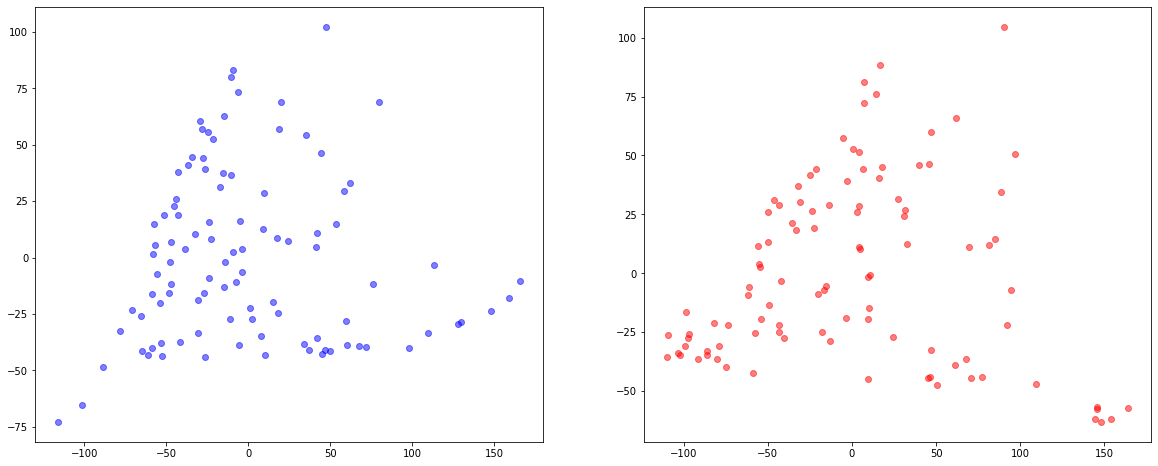

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.scatter(lig_reduced[:,0], lig_reduced[:,1], color='blue', alpha=0.5)
ax2.scatter(rec_reduced[:,0], rec_reduced[:,1], color='red', alpha=0.5)

# fig.savefig('lig_rec_keypts_PCA.png')
fig.show()

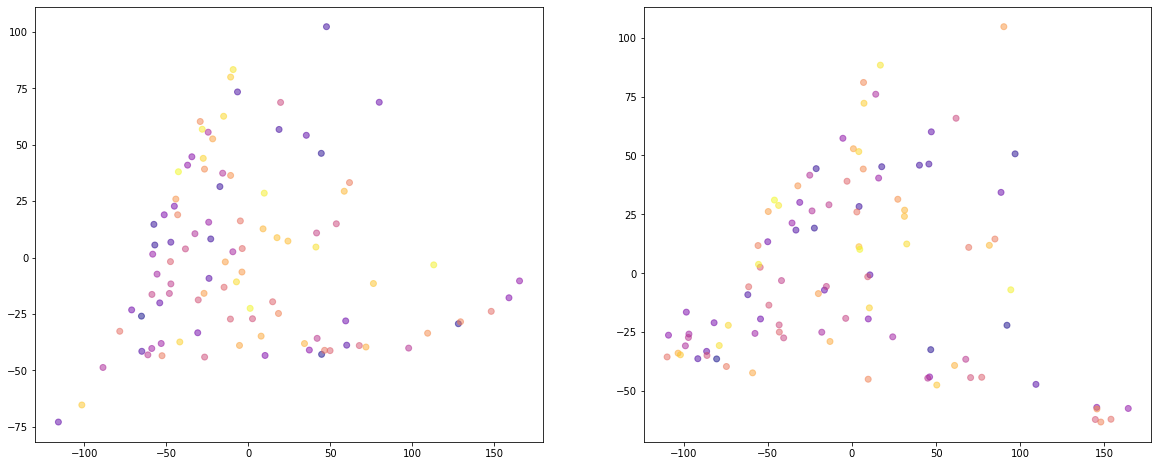

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
colors = np.linspace(0, 1, num = len(lig_reduced))
ax1.scatter(lig_reduced[:,0], lig_reduced[:,1], c=colors, cmap='plasma', alpha=0.5)
ax2.scatter(rec_reduced[:,0], rec_reduced[:,1], c=colors, cmap='plasma', alpha=0.5)

# fig.savefig('pairs_keypts_PCA.png')
fig.show()

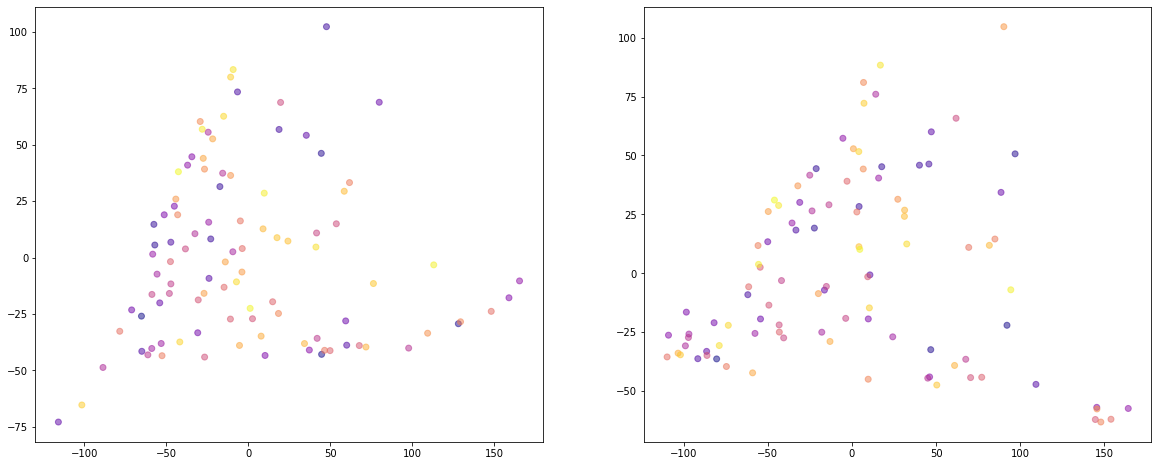

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

rec_colors = []
lig_colors = []
for name in names[:100]:
    
    rec, lig = complex_to_rec_lig[name]
    rec_colors.append( rec_ids[rec]/len(rec_ids) )
    lig_colors.append( lig_ids[lig]/len(lig_ids) )

    
colors = np.linspace(0, 1, num = len(lig_reduced))
ax1.scatter(lig_reduced[:,0], lig_reduced[:,1], c=rec_colors, cmap='plasma', alpha=0.5)
ax2.scatter(rec_reduced[:,0], rec_reduced[:,1], c=lig_colors, cmap='plasma', alpha=0.5)

# fig.savefig('thing.png')
fig.show()

In [10]:
complex_to_rec_lig = data['complex_to_rec_lig']

In [11]:
rec_ids, lig_ids = data['rec_ids'], data['lig_ids']

In [12]:
rec_freq, lig_freq = {}, {}
for comp in complex_to_rec_lig:
    rec, lig = complex_to_rec_lig[comp]
    
    if rec in rec_freq:
        rec_freq[rec] += 1
    else:
        rec_freq[rec] = 1
        
    if lig in lig_freq:
        lig_freq[lig] += 1
    else:
        lig_freq[lig] = 1

In [13]:
rec_tuples, lig_tuples = [(rec, rec_freq[rec]) for rec in rec_freq], [(lig, lig_freq[lig]) for lig in lig_freq]

In [14]:
rec_tuples.sort(key=lambda tup: tup[1], reverse=True)
lig_tuples.sort(key=lambda tup: tup[1], reverse=True)

In [42]:
num_freq = 5

In [43]:
recs = [rec_tup[0] for rec_tup in rec_tuples[:num_freq]]
ligs = [lig_tup[0] for lig_tup in lig_tuples[:num_freq]]

In [44]:
lig_indices, rec_indices = [], []
for i in range(len(names)):
    if complex_to_rec_lig[names[i]][0] in recs:
        rec_indices.append(i)
    
    if complex_to_rec_lig[names[i]][1] in ligs:
        lig_indices.append(i)

In [45]:
print(len(rec_indices), len(lig_indices))

368 263


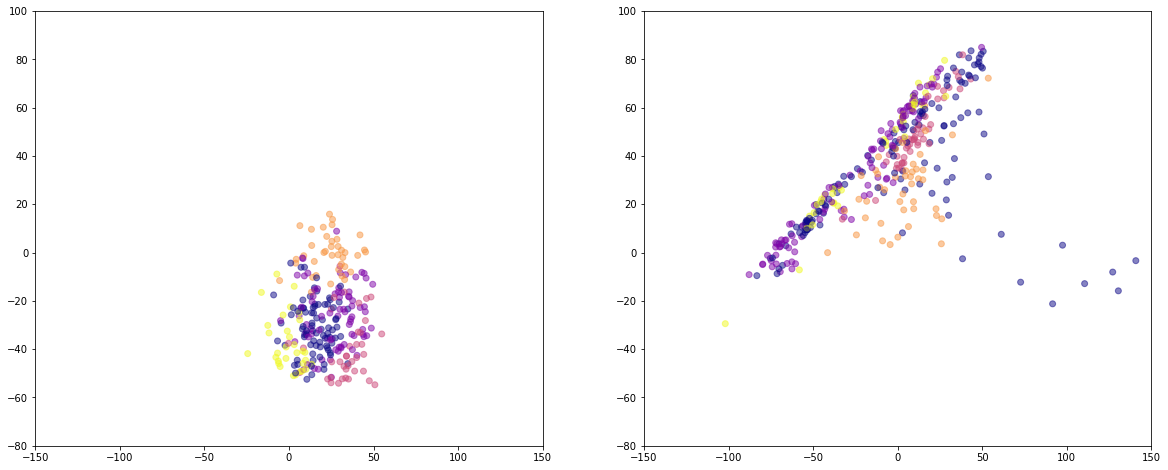

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

rec_colors, lig_colors = [], []
for rec_i in rec_indices:
    
    rec, lig = complex_to_rec_lig[names[rec_i]]
    rec_colors.append( recs.index(rec)/len(rec_indices) )
    
for lig_i in lig_indices:
    
    rec, lig = complex_to_rec_lig[names[lig_i]]
    lig_colors.append( ligs.index(lig)/len(lig_indices) )

    
visual_lig, visual_rec = np.take(reduced_ligand, lig_indices, axis=0), np.take(reduced_receptor, rec_indices, axis=0)
ax1.set_xlim(-150, 150)
ax1.set_ylim(-80, 100)
ax2.set_xlim(-150, 150)
ax2.set_ylim(-80, 100)
ax1.scatter(visual_lig[:,0], visual_lig[:,1], c=lig_colors, cmap='plasma', alpha=0.5)
ax2.scatter(visual_rec[:,0], visual_rec[:,1], c=rec_colors, cmap='plasma', alpha=0.5)


# fig.savefig('thing.png')
fig.show()

# Visualizing Protein-Ligand Pair, Fixed Protein, Different Ligands

In [13]:
def visualize_pair(lig_keypts, lig_coords, rec_keypts, rec_coords, name):
    
    lig_keypt_scatter = go.Scatter3d(x=lig_keypts[:, 0], 
                                    y=lig_keypts[:, 1], 
                                    z=lig_keypts[:, 2], 
                                    mode='markers', 
                                    name='Ligand Keypoints',
                                    marker=dict(size=3, color='blue', opacity=1))
    lig_coord_scatter = go.Scatter3d(x=lig_coords[:, 0], 
                                    y=lig_coords[:, 1], 
                                    z=lig_coords[:, 2], 
                                    mode='markers', 
                                    name='Ligand Coordinates',
                                    marker=dict(size=3, color='blue', opacity=0.5))
    rec_keypt_scatter = go.Scatter3d(x=rec_keypts[:, 0], 
                                    y=rec_keypts[:, 1], 
                                    z=rec_keypts[:, 2], 
                                    mode='markers', 
                                    name='Receptor Keypoints',
                                    marker=dict(size=3, color='red', opacity=1))
    rec_coord_scatter = go.Scatter3d(x=rec_coords[:, 0], 
                                    y=rec_coords[:, 1], 
                                    z=rec_coords[:, 2], 
                                    mode='markers', 
                                    name='Receptor Keypoints',
                                    marker=dict(size=3, color='red', opacity=0.5))
    """
    get_edgeIDs = lambda graph : torch.t( torch.vstack((graph.edges()[0], graph.edges()[1])) ).cpu().numpy()
    
    ligand_edges = get_edgeIDs(ligand_graph)
    receptor_edges = get_edgeIDs(receptor_graph)
    
    ligand_Xe = []
    ligand_Ye = []
    ligand_Ze = []

    receptor_Xe = []
    receptor_Ye = []
    receptor_Ze = []

    for e in ligand_edges:
        ligand_Xe += [ligand_coord[e[0], 0], ligand_coord[e[1], 0], None]
        ligand_Ye += [ligand_coord[e[0], 1], ligand_coord[e[1], 1], None]
        ligand_Ze += [ligand_coord[e[0], 2], ligand_coord[e[1], 2], None]

    for e in receptor_edges:
        receptor_Xe += [receptor_coord[e[0], 0], receptor_coord[e[1], 0], None]
        receptor_Ye += [receptor_coord[e[0], 1], receptor_coord[e[1], 1], None]
        receptor_Ze += [receptor_coord[e[0], 2], receptor_coord[e[1], 2], None]
        
        
    ligand_edges = go.Scatter3d(x=ligand_Xe, y=ligand_Ye, z=ligand_Ze, name='', mode='lines', line=dict(color='rgb(125,125,125)', width=.5), hoverinfo='none')
    receptor_edges = go.Scatter3d(x=receptor_Xe, y=receptor_Ye, z=receptor_Ze, name='', mode='lines', line=dict(color='rgb(125,125,125)', width=.5), hoverinfo='none')
    """
    
    graph_objects = [lig_keypt_scatter, rec_keypt_scatter, lig_coord_scatter, rec_coord_scatter,
                     #ligand_edges, receptor_edges
                    ]

    fig = go.Figure(data=graph_objects, 
                    layout=dict(scene=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False)))
                    )
    
    fig.write_html(f"{name}.html")
    fig.show()

In [14]:
rec_mapping = data['rec_to_complex_lig']

In [15]:
best_protein, max_length = '', 0
for mapped in rec_mapping:
    if len(rec_mapping[mapped]) > max_length:
        best_protein = mapped
        max_length = len(rec_mapping[mapped])

In [16]:
complexes = [pair[0] for pair in rec_mapping[best_protein][:5]]

In [17]:
complexes

['2fx6', '1pph', '1ce5', '1o3f', '1o3l']

In [18]:
indices = []
for i in range(len(names)):
    if names[i] in complexes:
        indices.append(i)

In [33]:
i = 4

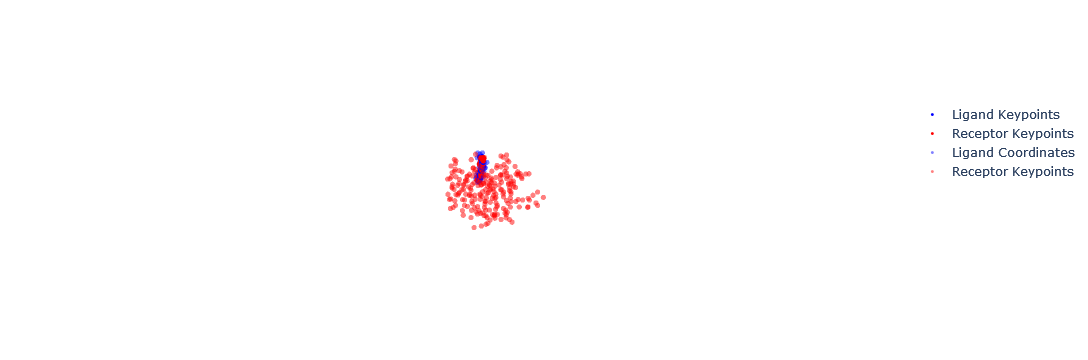

In [34]:
visualize_pair(lig_keypts[indices[i]].numpy(), lig_coords[indices[i]].numpy(), rec_keypts[indices[i]].numpy(), rec_coords[indices[i]], names[indices[i]])